In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)
# 如果使用CPU，需要非常长的时间，建议减少模型规模来加快速度（比如n_layer）

In [ ]:
# 一些超参数
emb_size = 128
head_size = 8
n_layer = 12
sequence_len = 64
learning_rate = 1e-3
eval_iters = 20
batch_size=500
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
raw_datasets = load_dataset("Nan-Do/code-search-net-python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repo'])
class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

tokenizer = CharTokenizer(datasets['original_string'])
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

In [ ]:
def process(data, tokenizer, sequence_len=sequence_len):
    text = data['original_string']
    # text is list[str]
    inputs, labels = [], []
    for t in text:
        enc = tokenizer.encode(t)
        enc += [tokenizer.end_ind]
        # 有bug，无法处理长度过小的数据
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)

f = lambda x: process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)


In [ ]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
next(iter(train_loader))

In [ ]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
    # context: (1, T)
    #out = []
    out = context.tolist()[0]
    model.eval()
    for _ in range(max_new_tokens):
        # 由于注意力机制的长度限制，截断背景
        logits = model(context[:, -sequence_len:])
        probs = F.softmax(logits[:, -1, :], dim=-1)  # (1, 98)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        # 更新背景
        context = torch.concat((context, ix), dim=-1)
        out.append(ix.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [ ]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']  # (B, T)
        logits = model(inputs)                           # (B, T, vs)
        # 请参考官方文档
        loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
    return torch.tensor(loss).mean().item()

In [ ]:
def train_model(model, optimizer, epochs=10):
    # 记录模型在训练集上的模型损失
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['inputs'], data['labels']  # (B, T)
            optimizer.zero_grad()
            logits = model(inputs)                           # (B, T, vs)
            loss = F.cross_entropy(logits.transpose(-2, -1), labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

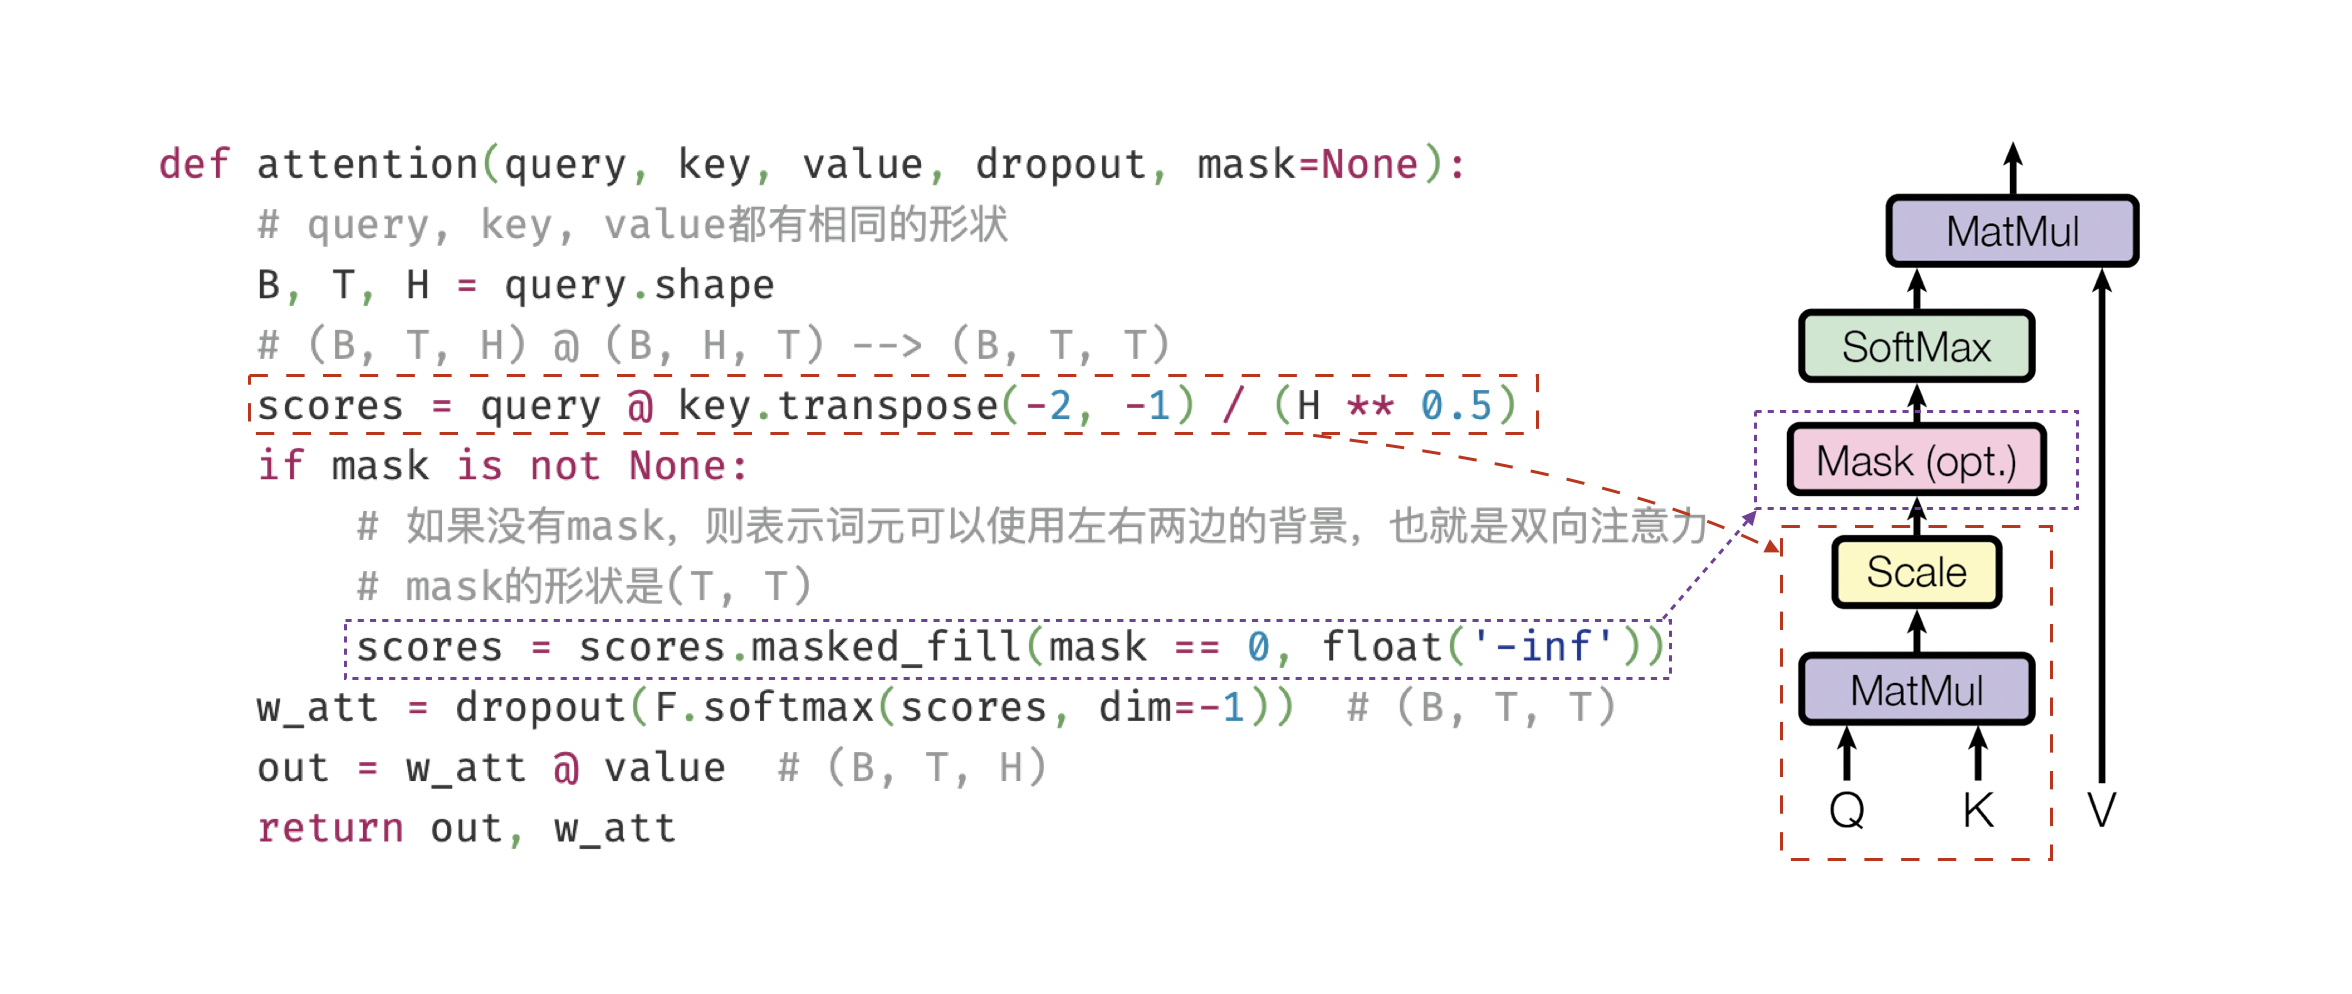

In [ ]:
def attention(query, key, value, dropout, mask=None):
  # query, key, value: (B, T, H)
  # mask:        (T, T)
  # output:       (B, T, H)
  B, T, H = query.shape
  scores = query @ key.transpose(-2, -1) / H ** 0.5
  if mask is not None:
    scores = scores.masked_fill(mask == 0, float('-inf'))
  w_att = F.softmax(scores, dim=-1) # (B, T, T)
  out = w_att @ value       # (B, T, H)
  return out

In [ ]:
class MaskedAttention(nn.Module):
  # 单向自注意力
  def __init__(self, emb_size, head_size):
    # emb_size: C, head_size: H
    super().__init__()
    self.key = nn.Linear(emb_size, head_size, bias=False)
    self.query = nn.Linear(emb_size, head_size, bias=False)
    self.value = nn.Linear(emb_size, head_size, bias=False)
    # 定义下三角矩阵
    self.register_buffer('tril', torch.tril(torch.ones(sequence_len, sequence_len)))
    self.dp = nn.Dropout(0.4)

  def forward(self, x):
    # x:   (B, T, C)
    # out: (B, T, H)
    B, T, C = x.shape
    k = self.key(x)    # (B, T, H)
    q = self.query(x)  # (B, T, H)
    v = self.value(x)  # (B, T, H)
    mask = self.tril[:T, :T]
    out = attention(q, k, v, self.dp, mask)
    return out


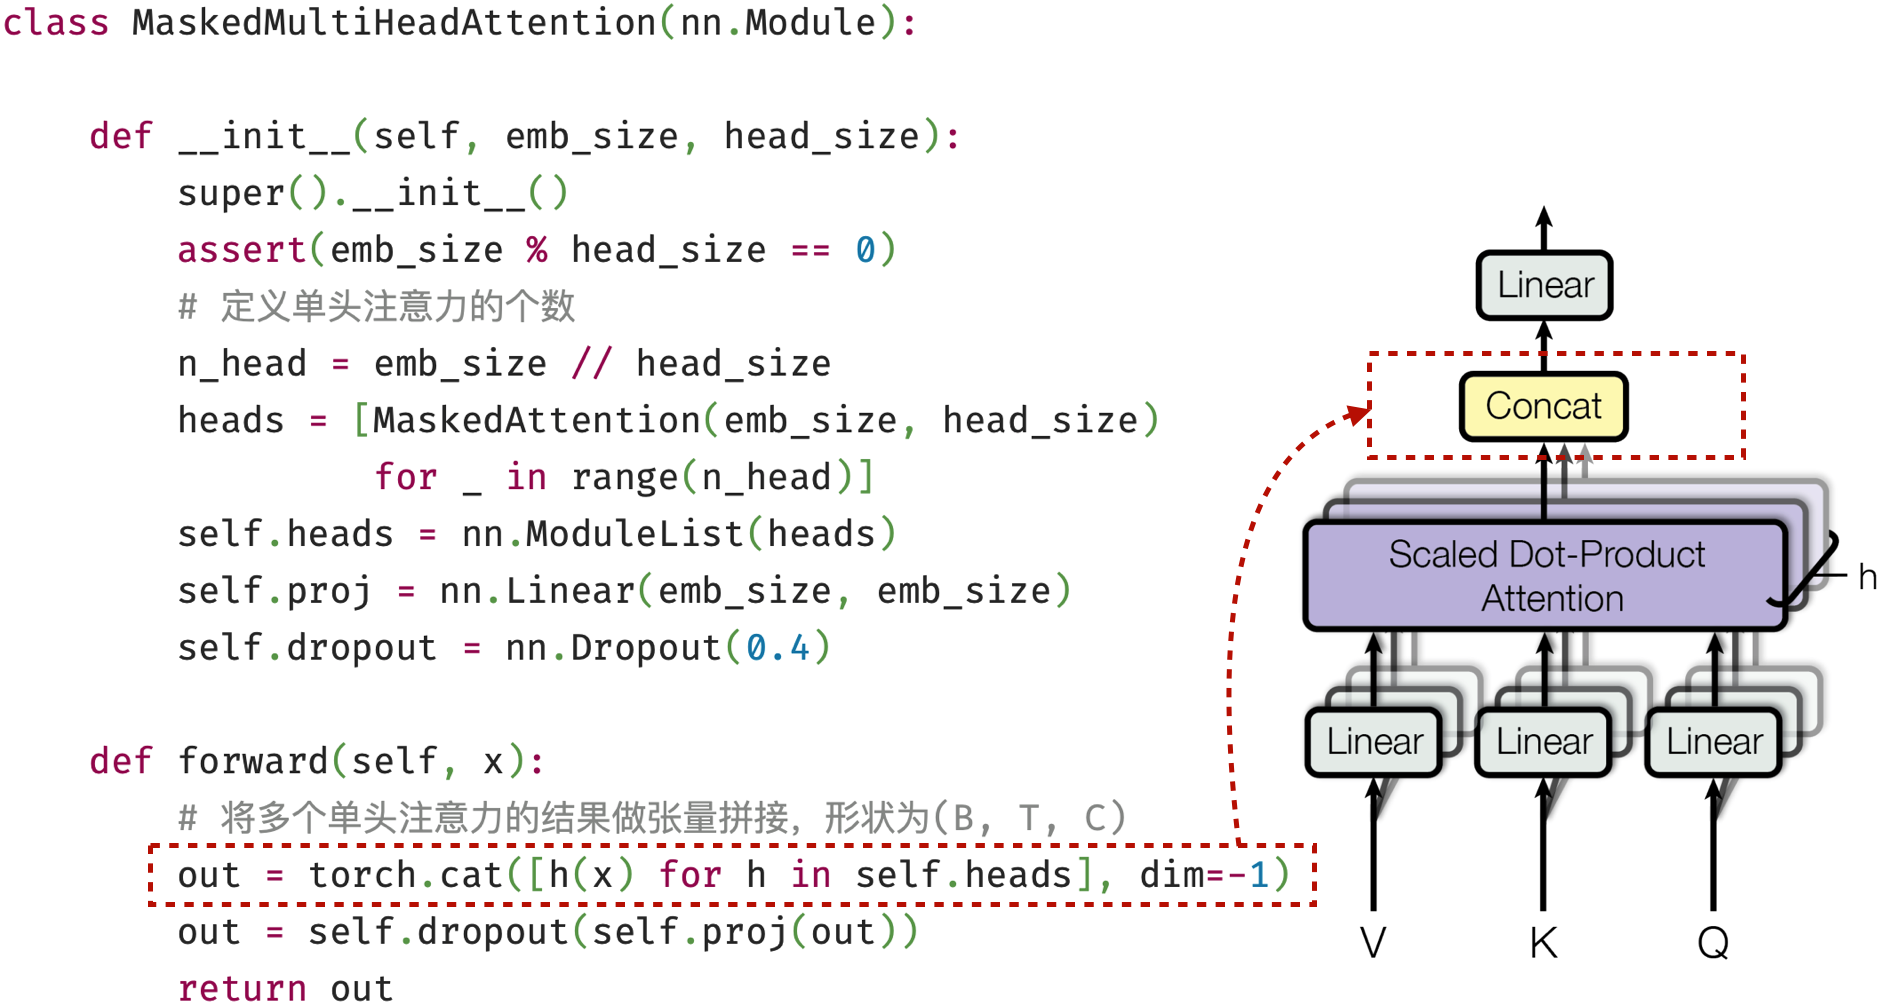

In [ ]:
class MaskedMultiHeadAttention(nn.Module):

  def __init__(self, emb_size, head_size):
    super().__init__()
    # 计算单头注意力的个数
    n_head = emb_size // head_size
    heads = [MaskedAttention(emb_size, head_size) for _ in range(n_head)]
    self.heads = nn.ModuleList(heads)
    self.proj = nn.Linear(emb_size, emb_size)
    self.dp = nn.Dropout(0.4)

  def forward(self, x):
    # x:   (B, T, C)
    # out: (B, T, C)
    out = torch.concat([h(x) for h in self.heads], dim=-1)  # (B, T, C)
    out = self.dp(self.proj(out))                           # (B, T, C)
    return out

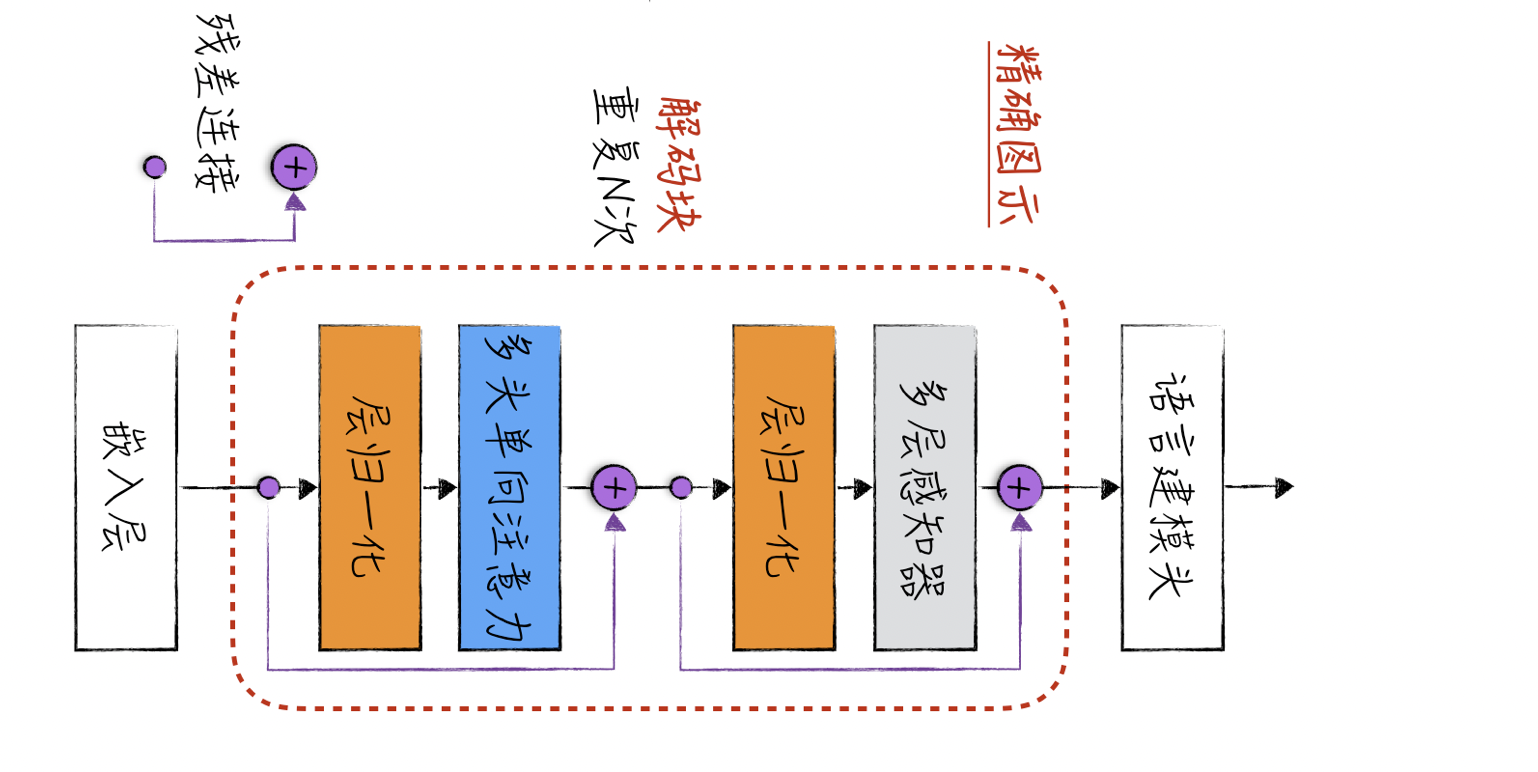

In [ ]:
# 多层感知器部分，先扩维度，再降回来
class FeedForward(nn.Module):
  def __init__(self, emb_size):
    super().__init__()
    self.ln1 = nn.Linear(emb_size, 4 * emb_size)
    self.ln2 = nn.Linear(4 * emb_size, emb_size)
    self.dp = nn.Dropout(0.4)

  def forward(self, x):
    # x : (B, T, C)
    out = F.gelu(self.ln1(x))   # (B, T, 4C)
    out = self.dp(self.ln2(out)) # (B, T, C)
    return out

In [ ]:
class Block(nn.Module):

  def __init__(self, emb_size, head_size):
    super().__init__()
    self.l1 = nn.LayerNorm(emb_size)
    self.mha = MaskedMultiHeadAttention(emb_size, head_size)
    self.l2 = nn.LayerNorm(emb_size)
    self.ff = FeedForward(emb_size)

  def forward(self, x):
    # x:   (B, T, C)
    # out: (B, T, C)
    # 千万不要使用+=！！！
    x = x + self.mha(self.l1(x))
    x = x + self.ff(self.l2(x))
    return x

In [ ]:
class CharGPT(nn.Module):

  def __init__(self, vs):
    super().__init__()
    self.token_emb = nn.Embedding(vs, emb_size)
    self.pos_emb = nn.Embedding(sequence_len, emb_size)
    block = [Block(emb_size, head_size) for _ in range(n_layer)]
    self.blocks = nn.Sequential(*block)
    self.l = nn.LayerNorm(emb_size)
    self.lm = nn.Linear(emb_size, vs)

  def forward(self, x):
    # x: (B, T)
    # logits: (B, T, vs)
    B, T = x.shape
    pos = torch.arange(0, T, dtype=torch.long, device=x.device)
    token_embeddings = self.token_emb(x)        # (B, T, C)
    position_embeddings = self.pos_emb(pos)     # (   T, C)
    h = token_embeddings + position_embeddings  # (B, T, C)
    h = self.blocks(h)                          # (B, T, C)
    logits = self.lm(self.l(h))                 # (B, T, vs)
    return logits

In [ ]:
c_model = CharGPT(len(tokenizer.char2ind)).to(device)
c_model, sum(p.numel() for p in c_model.parameters())

In [ ]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

In [ ]:
estimate_loss(c_model)

In [ ]:
l = train_model(c_model, optim.AdamW(c_model.parameters(), lr=learning_rate))

In [ ]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))